In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from PIL import Image


# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

"""# **Define Network | Physics-informed**"""

class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()

        for i in range(len(layers) - 1):
            layer = nn.Linear(layers[i], layers[i + 1])
            nn.init.xavier_uniform_(layer.weight)  # Xavier initialization for weights
            nn.init.zeros_(layer.bias)             # Initialize biases to zero
            self.layers.append(layer)

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = torch.tanh(self.layers[i](x))
        x = self.layers[-1](x)
        return x

# Define the network architecture
neuron_num = 20
#layers = [3,  20, 20, 20, 20, 20, 20, 20, 20,  4]  # Input: (x, y), Output: (u, v, p)
layers = [3, neuron_num, neuron_num, neuron_num, neuron_num, neuron_num, neuron_num, neuron_num, 4]  # Input: (x, y), Output: (u, v, p)
model = PINN(layers).to(device)

"""# **Define Desired PDE**"""

def navier_stokes_loss(model, x, y, z, mu):
    x = x.requires_grad_(True)
    y = y.requires_grad_(True)
    z = z.requires_grad_(True)

    uvp = model(torch.cat((x, y, z), dim=1))
    u = uvp[:, 0:1]
    v = uvp[:, 1:2]
    w = uvp[:, 2:3]
    p = uvp[:, 3:4]

    # Calculate gradients
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_z = torch.autograd.grad(u, z, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_z = torch.autograd.grad(v, z, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    w_x = torch.autograd.grad(w, x, grad_outputs=torch.ones_like(w), create_graph=True)[0]
    w_y = torch.autograd.grad(w, y, grad_outputs=torch.ones_like(w), create_graph=True)[0]
    w_z = torch.autograd.grad(w, z, grad_outputs=torch.ones_like(w), create_graph=True)[0]

    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    u_zz = torch.autograd.grad(u_z, z, grad_outputs=torch.ones_like(u_z), create_graph=True)[0]

    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
    v_zz = torch.autograd.grad(v_z, z, grad_outputs=torch.ones_like(v_z), create_graph=True)[0]

    w_xx = torch.autograd.grad(w_x, x, grad_outputs=torch.ones_like(w_x), create_graph=True)[0]
    w_yy = torch.autograd.grad(w_y, y, grad_outputs=torch.ones_like(w_y), create_graph=True)[0]
    w_zz = torch.autograd.grad(w_z, z, grad_outputs=torch.ones_like(w_z), create_graph=True)[0]

    p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    p_z = torch.autograd.grad(p, z, grad_outputs=torch.ones_like(p), create_graph=True)[0]

    # Navier-Stokes equations

    f_u = u*u_x + v*u_y + w*u_z + p_x - mu * (u_xx + u_yy + u_zz)
    f_v = u*v_x + v*v_y + w*v_z + p_y - mu * (v_xx + v_yy + v_zz)
    f_w = u*w_x + v*w_y + w*w_z + p_z - mu * (w_xx + w_yy + w_zz)

    # Continuity equation
    continuity = u_x + v_y + w_z

    # Loss calculation with balancing factors
    loss_momentum =  (torch.mean(f_u**2) + torch.mean(f_v**2)+ torch.mean(f_w**2))
    loss_continuity = torch.mean(continuity**2)
    return loss_momentum , loss_continuity

def boundary_condition_loss(model, x_b, y_b, z_b, u_b, v_b, w_b, p_b=None):
    uvp_b = model(torch.cat((x_b, y_b, z_b), dim=1))
    u_b_pred = uvp_b[:, 0:1]
    v_b_pred = uvp_b[:, 1:2]
    w_b_pred = uvp_b[:, 2:3]
    p_b_pred = uvp_b[:, 3:4]

    loss_u_b = torch.mean((u_b_pred - u_b) ** 2)
    loss_v_b = torch.mean((v_b_pred - v_b) ** 2)
    loss_w_b = torch.mean((w_b_pred - w_b) ** 2)
    loss_p_b = torch.mean((p_b_pred - p_b) ** 2)

    return loss_u_b + loss_v_b + loss_w_b #+ loss_p_b

def data_loss(model,x,y,z, u_exact, v_exact, w_exact, p_exact=None):
    uvp_pred = model(torch.cat((x, y, z), dim=1))
    u_pred = uvp_pred[:, 0:1]
    v_pred = uvp_pred[:, 1:2]
    w_pred = uvp_pred[:, 2:3]
    p_pred = uvp_pred[:, 3:4] if p_exact is not None else None

    loss_u = torch.mean((u_pred - u_exact) ** 2)
    loss_v = torch.mean((v_pred - v_exact) ** 2)
    loss_w = torch.mean((w_pred - w_exact) ** 2)
    loss_p = torch.mean((p_pred - p_exact) ** 2) if p_exact is not None else 0

    return loss_u + loss_v + loss_w + (loss_p if p_exact is not None else 0)



def total_loss(model, x, y, z, u_exact, v_exact,w_exact,p_exact,
               mu, x_b , y_b, z_b, u_b, v_b, w_b,p_b,
               weight_momentum,weight_continuity , loss_data ,lambda_bc):



    # Physics-informed loss
    mom_loss, cont_loss = navier_stokes_loss(model, x, y, z, mu)
    momentum_loss  = mom_loss * weight_momentum
    continuity_loss  = cont_loss * weight_continuity



    # Data loss

    loss_data = data_loss(model, x, y, z, u_exact, v_exact, w_exact, p_exact) * lambda_data

    # Boundary condition loss
    loss_bc = boundary_condition_loss(model, x_b, y_b,z_b, u_b, v_b,w_b, p_b) * lambda_bc if x_b is not None else 0
    loss = momentum_loss + continuity_loss + loss_data + loss_bc

    return loss, momentum_loss , continuity_loss , loss_data , loss_bc

# Load data from CSV
bound = 7500 # number of samples coorporated in traing
data = pd.read_csv('around_building_clip.csv')
data = (data - data.min()) / (data.max() - data.min())
data['y'] = 2

x = torch.tensor(data[['x']][:bound].values, dtype=torch.float32).to(device)
y = torch.tensor(data[['y']][:bound].values, dtype=torch.float32).to(device)
z = torch.tensor(data[['z']][:bound].values, dtype=torch.float32).to(device)
u_exact = torch.tensor(data[['u']][:bound].values, dtype=torch.float32).to(device)
v_exact = torch.tensor(data[['v']][:bound].values, dtype=torch.float32).to(device)
w_exact = torch.tensor(data[['w']][:bound].values, dtype=torch.float32).to(device)
p_exact = torch.tensor(data[['p']][:bound].values, dtype=torch.float32).to(device) if 'p' in data.columns else None



# Example boundary data (you may need to replace this with actual data)

bc_data = pd.read_csv('singleCube_BC.csv')
bc_data = (bc_data - bc_data.min()) / (bc_data.max() - bc_data.min())
bc_data['v'] = bc_data['w'] = 0
x_b = (torch.tensor(bc_data['x'], dtype=torch.float32).to(device)).reshape(-1,1)
y_b = (torch.tensor(bc_data['y'], dtype=torch.float32).to(device)).reshape(-1,1)
z_b = (torch.tensor(bc_data['z'], dtype=torch.float32).to(device)).reshape(-1,1)
u_b = (torch.tensor(bc_data['u'], dtype=torch.float32).to(device)).reshape(-1,1)  # Boundary u-values
v_b = (torch.tensor(bc_data['v'], dtype=torch.float32).to(device)).reshape(-1,1)  # Boundary v-values
w_b = (torch.tensor(bc_data['w'], dtype=torch.float32).to(device)).reshape(-1,1)  # Boundary w-values
p_b = (torch.tensor(bc_data['p'], dtype=torch.float32).to(device)).reshape(-1,1)  # Boundary w-values


# Training parameters
epochs =500
mu = 1E-5/1.225  # Dynamic viscosity
weight_momentum = 1
weight_continuity = 1
lambda_data = 100
lambda_bc = 1

# Define the optimizer
#optimizer = optim.Adam(model.parameters(), lr=1e-5)
optimizer=torch.optim.LBFGS(model.parameters(),
    lr=0.001,  # or adjust based on your problem
    max_iter=500,  # More iterations for better convergence
    max_eval=None,  # Default
    tolerance_grad=1e-7,  # Increase sensitivity to gradients
    tolerance_change=1e-9,  # Keep default unless facing early stops
    history_size=100  # Use larger history for better approximations
)

def closure():
    optimizer.zero_grad()
    loss, momentum_loss , continuity_loss , loss_data , loss_bc = total_loss(model, x, y, z, u_exact, v_exact,w_exact,p_exact,
               mu, x_b , y_b, z_b, u_b, v_b, w_b,p_b,
               weight_momentum,weight_continuity ,  lambda_bc,lambda_bc)
    loss.backward()
    return loss



for epochs in range(epochs):
    model.train()
    loss = optimizer.step(closure)




    if epochs % 10 == 0:
        print(f'Epoch {epochs}, Total Loss: {loss.item():.5f}')
        #print(f'The highest Loss is:  {max(momentum_loss.item() , continuity_loss.item() , loss_data.item() , loss_bc.item()):.6f}')
        #print(time.time())

model.eval()
with torch.no_grad():
    uvp_pred = model(torch.cat((x, y, z), dim=1))
    u_pred = uvp_pred[:, 0:1]
    v_pred = uvp_pred[:, 1:2]
    w_pred = uvp_pred[:, 2:3]
    p_pred = uvp_pred[:, 3:4]




Epoch 0, Total Loss: 113.52155
Epoch 10, Total Loss: 0.91178
Epoch 20, Total Loss: 0.44346
Epoch 30, Total Loss: 0.41048
Epoch 40, Total Loss: 0.40160
Epoch 50, Total Loss: 0.40020
Epoch 60, Total Loss: 0.40014
Epoch 70, Total Loss: 0.40012
Epoch 80, Total Loss: 0.40011
Epoch 90, Total Loss: 0.40011
Epoch 100, Total Loss: 0.40010
Epoch 110, Total Loss: 0.40009
Epoch 120, Total Loss: 0.40009
Epoch 130, Total Loss: 0.40008
Epoch 140, Total Loss: 0.40008
Epoch 150, Total Loss: 0.40008
Epoch 160, Total Loss: 0.40008
Epoch 170, Total Loss: 0.40008
Epoch 180, Total Loss: 0.40008
Epoch 190, Total Loss: 0.40008
Epoch 200, Total Loss: 0.40007
Epoch 210, Total Loss: 0.40007
Epoch 220, Total Loss: 0.40007
Epoch 230, Total Loss: 0.40007
Epoch 240, Total Loss: 0.40007
Epoch 250, Total Loss: 0.40007
Epoch 260, Total Loss: 0.40007
Epoch 270, Total Loss: 0.40007
Epoch 280, Total Loss: 0.40007
Epoch 290, Total Loss: 0.40007
Epoch 300, Total Loss: 0.40007
Epoch 310, Total Loss: 0.40007
Epoch 320, Total 

KeyboardInterrupt: 

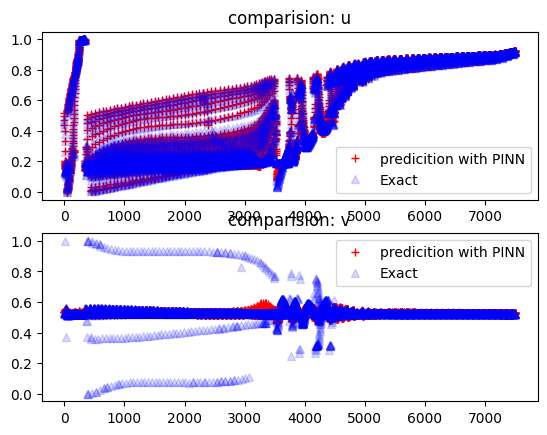

<Figure size 640x480 with 0 Axes>

In [5]:

def plot_result(model, x,y,z, u,v,w, al):
    uvwp_pred = model(torch.cat((x, y, z), dim=1))
    u_pred = uvwp_pred[:,0]
    v_pred = uvwp_pred[:,1]
    plt.figure(dpi = 100)
    plt.subplot(2,1,1)
    plt.title("comparision: " + "u" )
    plt.plot(u_pred.cpu().detach().numpy(),ls = "", marker = "+",  color = "r",label= "predicition with PINN" )
    plt.plot( u_exact.cpu(), ls = "", marker = "^",color = "b", alpha = al , label = "Exact")
    plt.legend(loc = "best")


    plt.subplot(2,1,2)
    plt.title("comparision: " + "v" )
    plt.plot(v_pred.cpu().detach().numpy(),ls = "", marker = "+", color =  "r",label= "predicition with PINN" )
    plt.plot(v_exact.cpu(),ls = "", marker = "^", color = "b" ,alpha = al, label = "Exact")
    plt.legend(loc = "best")

    plt.figure(dpi = 100)

plot_result(model, x, y, z, u_exact, v_exact, w_exact, 0.15)



In [ ]:
x.size()

torch.Size([350, 1])

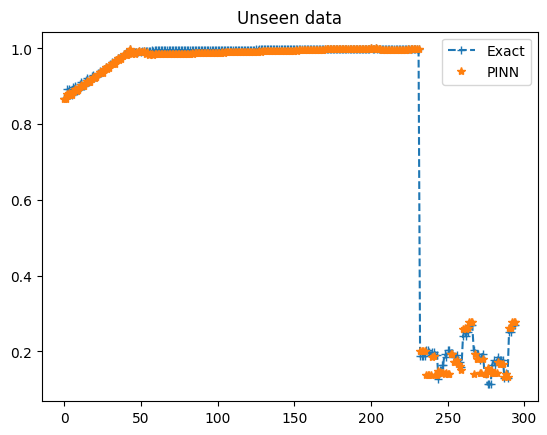

In [9]:
bound = 14500
"""# **Test with new Data**"""

x_test = torch.tensor(data[['x']][bound:].values, dtype=torch.float32).to(device)
y_test = torch.tensor(data[['y']][bound:].values, dtype=torch.float32).to(device)
z_test = torch.tensor(data[['z']][bound:].values, dtype=torch.float32).to(device)
u_test = torch.tensor(data[['u']][bound:].values, dtype=torch.float32).to(device)
v_test = torch.tensor(data[['v']][bound:].values, dtype=torch.float32).to(device)
w_test = torch.tensor(data[['w']][bound:].values, dtype=torch.float32).to(device)
p_test = torch.tensor(data[['p']][bound:].values, dtype=torch.float32).to(device)

uvp_test = model(torch.cat((x_test, y_test, z_test), dim=1))
ut_pred = uvp_test[:,0:1]

ut_pred = ut_pred.cpu().detach().numpy()
plt.figure(dpi= 100)
plt.title("Unseen data")
plt.plot(u_test.cpu(), ls = "--", marker = "+", label = "Exact")
plt.plot(ut_pred, ls = "", marker = "*", label = "PINN")
#plt.ylim(0.2,0.8)
plt.legend()
plt.show()


